In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import tensorflow.keras.layers as tkl

import numpy as np
import time
from IPython import display

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28*28).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28*28).astype('float32')

train_images /= 255.
test_images /= 255.

train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.
batch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)

In [3]:
class PredNet(tf.keras.Model):
    "Linear Layers, no tricks"
    def __init__(self, z):
        super(PredNet, self).__init__()
        self.latent_dim = z
        
        self.decoder = tf.keras.Sequential([
            tkl.InputLayer((z,)),
            tkl.Dense(32, activation='relu'),
            tkl.Dense(28*28, activation=tf.nn.sigmoid),
#             tkl.Reshape(target_shape=(28, 28, ))
        ])
        
        self.encoder = tf.keras.Sequential([
            tkl.InputLayer((28*28,)),
            tkl.Dense(32, activation='relu'),
            tkl.Dense(self.latent_dim, activation=tf.nn.tanh),            
        ])        
        
    def decode(self, x):
        return self.decoder(x)
    
    def encode(self, x):
        return self.encoder(x)
    
    def full_pass(self, x, y):
        pred = self.decode(y)
        err = x - pred
        z = self.encode(err)
        return z
        

In [4]:
optimizer = tf.keras.optimizers.Adam()

def compute_loss(model, x, y):
    y = model.full_pass(x, y)
    pred = model.decode(y)
    err = x - pred
    
    return -tf.reduce_mean(err**2)

def apply_gradients(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
def generate_images(model, test_input):
    preds_ = model.decode(test_input)
    predictions = tf.reshape(preds_, (16, 28, 28))
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4, i+1)
        plt.imshow(predictions[i,:,:], cmap='gray')
        plt.axis('off')
    plt.show()    

In [5]:
z = 10
model = PredNet(z)

In [6]:
num_examples = 16
rand_vec = tf.random.normal(shape=[num_examples, z])
y0 = tf.random.normal([batch_size,z])

Epoch: 1, Test set loss: -0.8672301769256592,time elapsed: 9.387983798980713


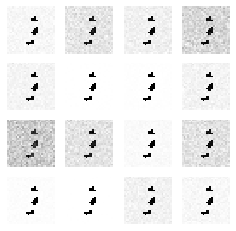

In [8]:
for epoch in range(2):
    start_time = time.time()
    for x in train_dataset:
         y0 = model.full_pass(x, y0)
         apply_gradients(model, x, y0, optimizer)   
    end_time = time.time()
    
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            y0 = model.full_pass(x, y0)
            loss(compute_loss(model, test_x, y0))
            loss_ = loss.result()
            display.clear_output(wait=True)
        print("Epoch: {}, Test set loss: {},"
                  "time elapsed: {}".format(epoch, 
                                            loss_,
                                            end_time - start_time))

    generate_images(model, rand_vec)

In [166]:
model.decode(y0)

<tf.Tensor: id=1571445, shape=(100, 784), dtype=float32, numpy=
array([[0.99921745, 0.9992433 , 0.999189  , ..., 0.99910575, 0.99913675,
        0.99925685],
       [0.99921745, 0.9992433 , 0.999189  , ..., 0.99910575, 0.99913675,
        0.99925685],
       [0.99921745, 0.9992433 , 0.999189  , ..., 0.99910575, 0.99913675,
        0.99925685],
       ...,
       [0.99921745, 0.9992433 , 0.999189  , ..., 0.99910575, 0.99913675,
        0.99925685],
       [0.99921745, 0.9992433 , 0.999189  , ..., 0.99910575, 0.99913675,
        0.99925685],
       [0.99921745, 0.9992433 , 0.999189  , ..., 0.99910575, 0.99913675,
        0.99925685]], dtype=float32)>

In [140]:
cnt = 0
for x in train_dataset:
     y0 = model.full_pass(x, y0)
     cnt += 1

In [135]:
cnt

900

In [112]:
rand_vec.shape

TensorShape([16, 16])

In [113]:
model.decode(rand_vec)

<tf.Tensor: id=20583, shape=(16, 784), dtype=float32, numpy=
array([[-0.10537411,  0.05193016,  0.01790936, ..., -0.04152266,
         0.04325836,  0.23722038],
       [ 0.04157636, -0.01008238,  0.00224819, ..., -0.12321901,
        -0.047409  ,  0.21976094],
       [ 0.09217097, -0.02528837,  0.0115513 , ..., -0.06597015,
        -0.1270804 ,  0.08402786],
       ...,
       [ 0.25595897,  0.0321898 ,  0.34293818, ..., -0.07445385,
        -0.42378765, -0.3124227 ],
       [ 0.19001815,  0.1546324 , -0.02177703, ...,  0.04285537,
        -0.08605777,  0.03356364],
       [-0.10406683,  0.0078279 ,  0.04952916, ..., -0.2082236 ,
         0.08769575,  0.16552079]], dtype=float32)>

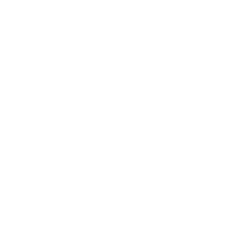

In [147]:
generate_images(model, rand_vec)